In [36]:
import pathlib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [41]:
! ls weak_scaling_data/

Untitled                              weak_fft_n=32768000000_p=512_11030112
weak_fft_n=1024000000_p=128_11029691  weak_fft_n=4096000000_p=128_11029701
weak_fft_n=1024000000_p=16_11029907   weak_fft_n=4096000000_p=512_11030104
weak_fft_n=128000000_p=16_11029687    weak_fft_n=512000000_p=16_11029699
weak_fft_n=16384000000_p=512_11030108 weak_fft_n=8192000000_p=128_11029908
weak_fft_n=250000_p=16_11018099


In [62]:
def global_depth(rank):
    """
    will return the first power of 8 greater than rank, the power corresponding to the level
    """
    level = 1
    loop = True

    while loop:

        if rank <= 8**level:
            loop = False
            result = level
        else:
            level += 1
    
    return result

v_global_depth = np.vectorize(global_depth)

def pow2(x): return np.log2(x).is_integer()

In [90]:
min_nodes = 32
max_nodes = 128

ranks_per_node = 32 # Say each rank gets a whole AMD EPYC ROME CPU
total_ranks = ranks_per_node * max_nodes

points_per_rank = 250e3
n = points_per_rank*total_ranks # total problem size
print(f"Total problem size n={n/1e9}B")

points_per_node = points_per_rank * ranks_per_node
print(f"points per rank {points_per_rank/1e6}M")
print(f"points per node {points_per_node/1e6}M")

# Double number of nodes used until we reach max_nodes
n_nodes = np.array(list(filter(pow2, [i for i in range(min_nodes, max_nodes+1)])))

# The global depth is a function of the ranks per node (as will need enough global leaves to cover this many ranks (local trees))
global_depth = v_global_depth(n_nodes*ranks_per_node)
print(f"global depth {global_depth}")

# local depth is a constant, chosen to balance M2L and P2P
local_depth = 4
points_per_leaf = points_per_rank / 8**local_depth 
print(f"points per leaf {points_per_leaf}")
print(f"MPI tasks {n_nodes*ranks_per_node}")

Total problem size n=1.024B
points per rank 0.25M
points per node 8.0M
global depth [4 4 4]
points per leaf 61.03515625
MPI tasks [1024 2048 4096]


In [91]:
print(n_nodes)

[ 32  64 128]


In [42]:
t1 = pd.read_csv('weak_scaling_data/weak_fft_n=128000000_p=16_11029687/weak_fft_11029687.csv')
# t2 = pd.read_csv('weak_scaling_data/weak_fft_n=1024000000_p=128_11029691/weak_fft_11029691.csv')
t2 = pd.read_csv('weak_scaling_data/weak_fft_n=1024000000_p=128_11029691/test.csv')
t2['experiment_id'] += t1['experiment_id'].max()+1

df_250k = pd.concat([t1, t2])

# Calculate nodes and ranks
df_250k["n_nodes"] = df_250k.groupby("experiment_id")["experiment_id"].transform(
    lambda x: 1 if len(x) / 32 < 1 else len(x)/32
)
df_250k["n_ranks"] = df_250k.groupby("experiment_id")["experiment_id"].transform(
    lambda x: len(x)
)
df_250k['total_points'] = df_250k['n_points'] * df_250k['n_ranks']

#### 
t1 = pd.read_csv('weak_scaling_data/weak_fft_n=512000000_p=16_11029699/weak_fft_11029699.csv')
t2 = pd.read_csv('weak_scaling_data/weak_fft_n=4096000000_p=128_11029701/weak_fft_11029701.csv')
t2['experiment_id'] += t1['experiment_id'].max()+1

df_1e6 = pd.concat([t1, t2])

df_1e6["n_nodes"] = df_1e6.groupby("experiment_id")["experiment_id"].transform(
    lambda x: 1 if len(x) / 32 < 1 else len(x)/32
)

df_1e6["n_ranks"] = df_1e6.groupby("experiment_id")["experiment_id"].transform(
    lambda x: len(x)
)
df_1e6['total_points'] = df_1e6['n_points'] * df_1e6['n_ranks']

##### 
t1 = pd.read_csv('weak_scaling_data/weak_fft_n=1024000000_p=16_11029907/weak_fft_n=1024000000_p=16_11029907.csv')
t2 = pd.read_csv('weak_scaling_data/weak_fft_n=8192000000_p=128_11029908/weak_fft_n=8192000000_p=128_11029908.csv')
t3 = pd.read_csv('weak_scaling_data/weak_fft_n=32768000000_p=512_11030112/weak_fft_n=32768000000_p=512_11030112.csv')

t2['experiment_id'] += t1['experiment_id'].max()+1
t3['experiment_id'] += t2['experiment_id'].max()+1
df_2e6 = pd.concat([t1, t2, t3])

df_2e6["n_nodes"] = df_2e6.groupby("experiment_id")["experiment_id"].transform(
    lambda x: 1 if len(x) / 32 < 1 else len(x)/32
)

df_2e6["n_ranks"] = df_2e6.groupby("experiment_id")["experiment_id"].transform(
    lambda x: len(x)
)

df_2e6['total_points'] = df_2e6['n_points'] * df_2e6['n_ranks']

In [43]:
plt.rcParams.update({
    "font.size": 9,         # base font size
    "axes.labelsize": 9,    # x/y labels
    "axes.titlesize": 9,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "font.family": "serif",  # or "sans-serif" for a cleaner look
    "text.usetex": False     # True if you want full LaTeX rendering
})


def set_size(width_cm, height_cm):
    """Helper to set figure size in cm."""
    return (width_cm / 2.54, height_cm / 2.54)


def weak_scaling_plot(df_vec, shrink=0.08, band_alpha=0.2):
    """
    df_vec: list of dataframes (each with experiment_id, total_points, n_nodes, runtime, ...)
    shrink: fraction to inset band edges on a log scale (per band)
    band_alpha: transparency of the shaded bands
    """
    fig, ax = plt.subplots(1, 3, figsize=set_size(35, 10))  # double column width
    
    shade_colors = ["tab:blue", "tab:orange"]

    for (i, df) in enumerate(df_vec):
        # aggregate per experiment
        grp = df.groupby('experiment_id')
        runtime = grp.mean()[['total_points', 'n_points', 'n_nodes', 'n_ranks', 'runtime']]
        runtime_err = grp.std()[['total_points', 'n_nodes', 'n_ranks', 'runtime']]

        # plot means + error bars
        ax[i].errorbar(
            runtime['total_points'],
            runtime['runtime'],
            yerr=runtime_err['runtime'],
            fmt='o-', capsize=4, label="Runtime", zorder=3
        )

        ax[i].set_xscale('log')
        ax[i].grid(True, zorder=0)

        # ----- build non-overlapping n_nodes regions on the x-axis -----
        # collect per-n_nodes x ranges + a representative x (median) to order regions along x
        bands = []
        for n, sub in runtime.groupby('n_nodes'):
            if sub.empty:
                continue
            x_min = sub['total_points'].min()
            x_max = sub['total_points'].max()
            x_rep = sub['total_points'].median()
            bands.append((int(n), x_min, x_max, x_rep))

        if not bands:
            continue

        # order the bands by their representative x (so bands won't overlap visually)
        bands.sort(key=lambda t: t[3])

        # compute region edges: [left edge of first band] + midpoints between reps + [right edge of last band]
        edges = [bands[0][1]]
        for k in range(len(bands) - 1):
            # geometric midpoint on log scale between representative x's
            mid = (bands[k][3] * bands[k+1][3]) ** 0.5
            edges.append(mid)
        edges.append(bands[-1][2])

        # now shade each band between consecutive edges, alternating colors
        # inset edges slightly in log-space so bands don't sit exactly on data limits
        # now shade each band between consecutive edges, alternating colors
        y0, y1 = ax[i].get_ylim()
        for j, (n, _, _, _) in enumerate(bands):
            left = edges[j]
            right = edges[j+1]
        
            if left <= 0 or right <= 0 or left >= right:
                continue
        
            # shrink inward on left, but extend right edge slightly
            log_left, log_right = np.log10(left), np.log10(right)
            pad = (log_right - log_left) * shrink
            log_left_adj = log_left + pad
            log_right_adj = log_right - pad
        
            # right-inclusive extension (+5% of width)
            # if j == (len(bands)-1):
            log_right_adj += (log_right - log_left) * 0.1

            if j == 0:
                log_left_adj -= (log_right - log_left) * 0.15

            if j == (len(bands)-1):
                log_right_adj += (log_right - log_left) * 0.1


            left_adj = 10 ** log_left_adj
            right_adj = 10 ** log_right_adj
        
            ax[i].axvspan(
                left_adj, right_adj,
                color=shade_colors[j % 2], alpha=band_alpha, zorder=1
            )
        
            # label in log-midpoint
            xmid = (left_adj * right_adj) ** 0.5
            y_label = y0 + 0.92 * (y1 - y0)
            y_label = y1 + 0.3*y1
            ax[i].text(
                xmid, y_label, f"{n} nodes",
                ha="center", va="top", rotation=90,
                fontsize=9, fontweight="bold",
                bbox=dict(facecolor="white", alpha=0.7, edgecolor="none"),
                zorder=4
            )


        # keep limits stable if shading changed them
        ax[i].set_ylim(y0, y1)

    ax[0].set_ylabel("Runtime (ms)")
    ax[1].set_xlabel("Number of Particles")
    fig.tight_layout()
    # fig.legend(loc="upper right", bbox_to_anchor=(0.98, 1.05))
    plt.show()


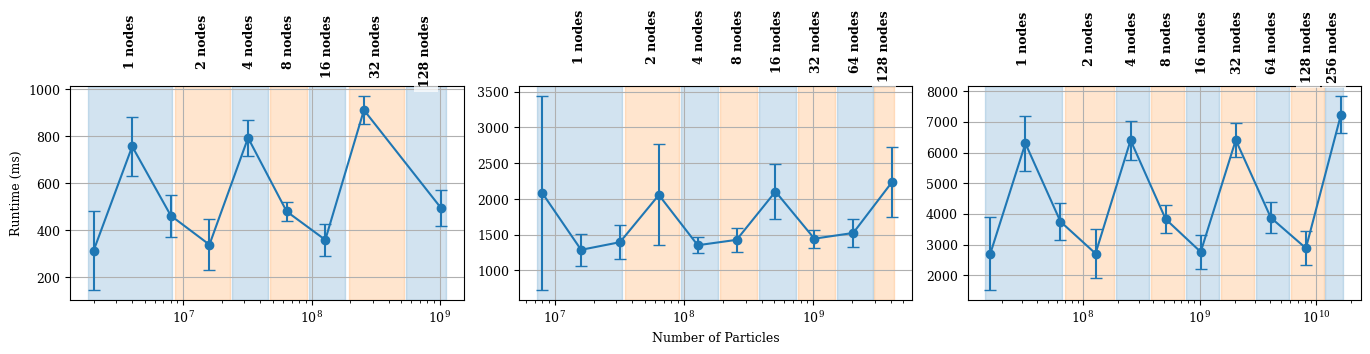

In [44]:
weak_scaling_plot([df_250k, df_1e6, df_2e6])

In [16]:
df_2e6.columns

Index(['experiment_id', 'rank', 'runtime', 'p2m', 'm2m', 'l2l', 'm2l', 'p2p',
       'source_tree', 'target_tree', 'source_domain', 'target_domain',
       'layout', 'ghost_exchange_v', 'ghost_exchange_v_runtime',
       'ghost_exchange_u', 'gather_global_fmm', 'scatter_global_fmm',
       'source_to_target_data', 'source_data', 'target_data', 'global_fmm',
       'ghost_fmm_v', 'ghost_fmm_u', 'displacement_map', 'metadata_creation',
       'expansion_order', 'n_points', 'local_depth', 'global_depth',
       'block_size', 'n_threads', 'n_samples', 'n_nodes', 'n_ranks',
       'total_points'],
      dtype='object')

In [25]:
tmp = df_2e6.groupby('experiment_id').mean()[['n_ranks', 'n_nodes', 'runtime', 'total_points', 'source_tree', 'm2l', 'p2p', 'local_depth']]
tmp

,n_ranks,n_nodes,runtime,total_points,source_tree,m2l,p2p,local_depth
experiment_id,,,,,,,,
0,8.0,1.0,2707.625000,1.600000e+07,24182.500000,1273.625000,1207.250000,5.0
1,16.0,1.0,6299.187500,3.200000e+07,15686.187500,5404.250000,629.250000,5.0
2,32.0,1.0,3750.375000,6.400000e+07,18838.062500,2746.531250,827.031250,5.0
3,64.0,2.0,2709.453125,1.280000e+08,23951.734375,1325.796875,1225.593750,5.0
4,128.0,4.0,6400.523438,2.560000e+08,16258.140625,5476.750000,630.390625,5.0
5,256.0,8.0,3830.542969,5.120000e+08,18787.957031,2765.609375,829.410156,5.0
6,512.0,16.0,2761.445312,1.024000e+09,25013.923828,1358.531250,1229.859375,5.0
7,1024.0,32.0,6407.586914,2.048000e+09,17878.924805,5184.622070,625.692383,5.0
8,2048.0,64.0,3876.565918,4.096000e+09,22884.522461,2639.126953,826.509766,5.0


In [32]:
df_250k.columns

Index(['experiment_id', 'rank', 'runtime', 'p2m', 'm2m', 'l2l', 'm2l', 'p2p',
       'source_tree', 'target_tree', 'source_domain', 'target_domain',
       'layout', 'ghost_exchange_v', 'ghost_exchange_v_runtime',
       'ghost_exchange_u', 'gather_global_fmm', 'scatter_global_fmm',
       'source_to_target_data', 'source_data', 'target_data', 'global_fmm',
       'ghost_fmm_v', 'ghost_fmm_u', 'displacement_map', 'metadata_creation',
       'expansion_order', 'n_points', 'local_depth', 'global_depth',
       'block_size', 'n_threads', 'n_samples', 'n_nodes', 'n_ranks',
       'total_points'],
      dtype='object')

In [31]:
df.columns

Index(['experiment_id', 'rank', 'runtime', 'p2m', 'm2m', 'l2l', 'm2l', 'p2p',
       'source_tree', 'target_tree', 'source_domain', 'target_domain',
       'layout', 'ghost_exchange_v', 'ghost_exchange_v_runtime',
       'ghost_exchange_u', 'gather_global_fmm', 'scatter_global_fmm',
       'source_to_target_data', 'source_data', 'target_data', 'global_fmm',
       'ghost_fmm_v', 'ghost_fmm_u', 'displacement_map', 'metadata_creation',
       'expansion_order', 'n_points', 'local_depth', 'global_depth',
       'block_size', 'n_threads', 'n_samples'],
      dtype='object')

In [30]:
df.groupby('experiment_id').mean()

,rank,runtime,p2m,m2m,l2l,m2l,p2p,source_tree,target_tree,source_domain,...,ghost_fmm_u,displacement_map,metadata_creation,expansion_order,n_points,local_depth,global_depth,block_size,n_threads,n_samples
experiment_id,,,,,,,,,,,,,,,,,,,,,
0,511.5,910.956055,12.051758,1.006836,1.280273,657.564453,111.202148,6297.000000,6253.0000,340.969727,...,0.0,3.0,250000.0,4.0,4.0,128.0,4.0,5000.0,NaN,NaN
2,2047.5,493.990723,4.479004,0.001953,0.004639,160.172119,191.774902,22184.558594,22150.0354,522.776123,...,0.0,3.0,250000.0,4.0,4.0,128.0,4.0,5000.0,NaN,NaN


In [23]:
tmp['total_points']/[tmp

experiment_id
0     2000000.0
1     2000000.0
2     2000000.0
3     2000000.0
4     2000000.0
5     2000000.0
6     2000000.0
7     2000000.0
8     2000000.0
9     2000000.0
10    2000000.0
dtype: float64